# Analysis of commits modifying `kernel/bpf/verifier.c` between `v6.3^..v6.13`

Note `commits.json` contains data on all commits that modify `kernel/bpf/verifier.c`. IOW, if the number of modified files is 1, then it must be verifier.c.

The data was collected using a wrapper around:

    git log {start_ref}^..{end_ref} --no-merges --pretty=format:'%H' -- {file_path}

Full source for the dataset collector is available at https://github.com/danobi/verifier-analysis.

In [38]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import json

with open('./commits.json', 'r') as f:
    data = json.load(f)

# Selftest changes we'll ignore for now. They can be trivially (but preferrably not) dropped.
commits = copy.deepcopy(data['commits'])
for commit in commits:
    commit['modified_files'] = [f for f in commit['modified_files'] if 'selftests' not in f]

## Part 1: Is the proof-of-concept useful?

The PoC is a light refactor to enable the verifier to be reloaded. In terms of architecture, it's still highly coupled to the base kernel.

It's a good first step, but practically only useful if changes are targeted at `kernel/bpf/verifier.c` alone, as any base kernel (headers, other files, etc) can cause ABI and/or semantic mismatches. Therefore, part 1 investigates how often verifier.c is changed in isolation.

An open question is whether or not applying single commits is effective, as there may be intra-patchset dependencies. For example:

* Patch 1 adds a new field to `include/linux/verifier.h`
* Patch 2 makes `kernel/bpf/verifier.c` take advantage of the new field
* Patch 3 adds a selftest

Patch 2 may appear to be applicable, but actually fail to compile. The alternate approach would be to analyze by patchset and not by commit. This is investigated further below.

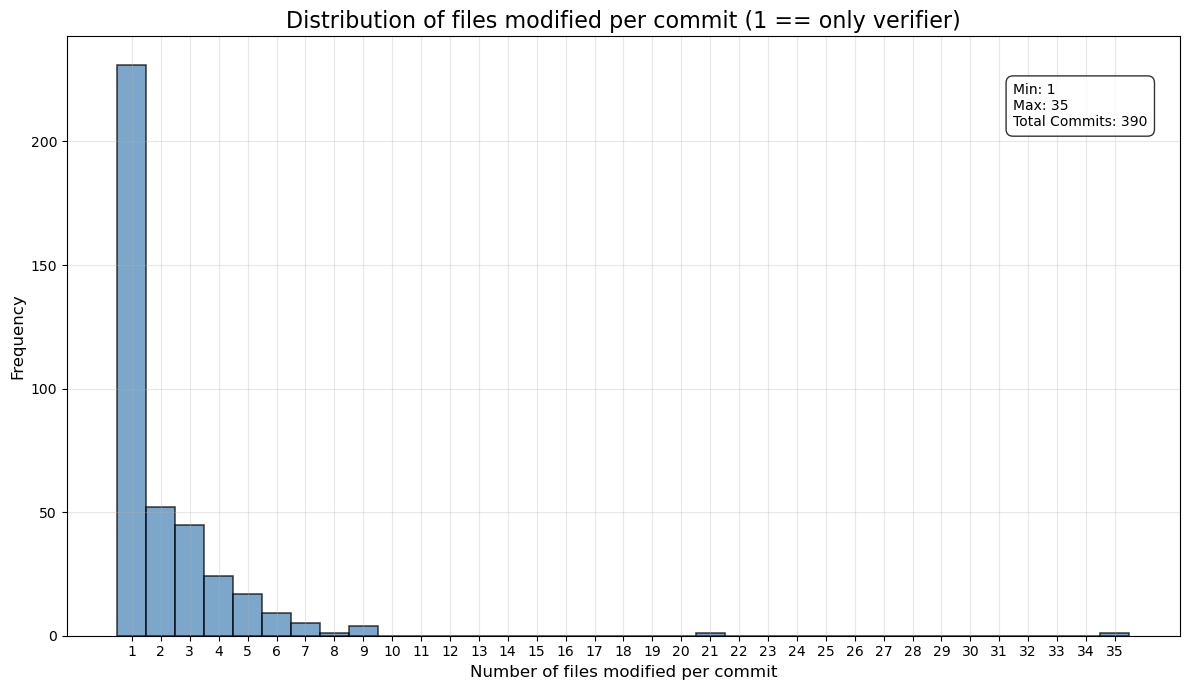

In [39]:
# Extract the number of files modified in each commit (NB: selftest changes ignored)
files_per_commit = [len(commit['modified_files']) for commit in commits]

# Create a figure
plt.figure(figsize=(12, 7))

# Create histogram with exact integer bins
# This creates bin edges at 0.5, 1.5, 2.5, etc. so each bin is centered on an integer
integer_bins = np.arange(0.5, max(files_per_commit) + 1.5, 1.0)
n, bins, patches = plt.hist(
    files_per_commit,
    bins=integer_bins,
    alpha=0.7,
    color='steelblue', 
    edgecolor='black',
    linewidth=1.2
)

# Add labels and title
plt.xlabel('Number of files modified per commit', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of files modified per commit (1 == only verifier)', fontsize=16)

# Set x-ticks at integer positions
plt.xticks(range(1, int(max(files_per_commit)) + 1))

# Add summary statistics as text
stats_text = '\n'.join([
    f"Min: {min(files_per_commit)}",
    f"Max: {max(files_per_commit)}",
    f"Total Commits: {len(files_per_commit)}",
])

plt.annotate(
    stats_text,
    xy=(0.85, 0.85),
    xycoords='axes fraction', 
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.8
    ),
)

# Add grid
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [54]:
def commit_sha(commit):
    sha = commit['hash']
    return sha[:8]

def commit_title(commit):
    # Hack for patchsets.json dataset in part 3
    if 'subject' in commit:
        return commit['subject']
    
    msg = commit['message']
    return msg.split('\n')[0]

def print_commit_list(commits):
    pretty = [f"({commit_sha(commit)})  {commit_title(commit)}" for commit in commits]
    print('\n'.join(pretty))

only_verifier = [commit for commit in commits if len(commit['modified_files']) == 1]
print(f"Number of commits only modifying verifier: {len(only_verifier)}\n")
print_commit_list(only_verifier)

Number of commits only modifying verifier: 231

(23579010)  bpf: Fix bpf_get_smp_processor_id() on !CONFIG_SMP
(ac6542ad)  bpf: fix null dereference when computing changes_pkt_data of prog w/o subprogs
(27e88bc4)  bpf: add find_containing_subprog() utility function
(b0e66977)  bpf: Fix narrow scalar spill onto 64-bit spilled scalar slots
(69772f50)  bpf: Don't mark STACK_INVALID as STACK_MISC in mark_stack_slot_misc
(bd74e238)  bpf: Zero index arg error string for dynptr and iter
(12659d28)  bpf: Ensure reg is PTR_TO_STACK in process_iter_arg
(17c4b65a)  bpf: Allow return values 0 and 1 for kprobe session
(d402755c)  bpf: Unify resource leak checks
(46f7ed32)  bpf: Tighten tail call checks for lingering locks, RCU, preempt_disable
(d0b98f6a)  bpf: disallow 40-bytes extra stack for bpf_fastcall patterns
(aa30eb32)  bpf: Force checkpoint when jmp history is too long
(99dde42e)  bpf: Handle BPF_UPTR in verifier
(9806f283)  bpf: fix do_misc_fixups() for bpf_get_branch_snapshot()
(8ea60733)

In [28]:
only_verifier_fixes = [commit for commit in only_verifier if 'Fixes: ' in commit['message']]
print(f"Number of commits only modifying verifier.c with 'Fixes:' tag: {len(only_verifier_fixes)}\n")
print_commit_list(only_verifier_fixes)

Number of commits only modifying verifier.c with 'Fixes:' tag: 73

(23579010)  bpf: Fix bpf_get_smp_processor_id() on !CONFIG_SMP
(ac6542ad)  bpf: fix null dereference when computing changes_pkt_data of prog w/o subprogs
(b0e66977)  bpf: Fix narrow scalar spill onto 64-bit spilled scalar slots
(69772f50)  bpf: Don't mark STACK_INVALID as STACK_MISC in mark_stack_slot_misc
(12659d28)  bpf: Ensure reg is PTR_TO_STACK in process_iter_arg
(17c4b65a)  bpf: Allow return values 0 and 1 for kprobe session
(46f7ed32)  bpf: Tighten tail call checks for lingering locks, RCU, preempt_disable
(d0b98f6a)  bpf: disallow 40-bytes extra stack for bpf_fastcall patterns
(aa30eb32)  bpf: Force checkpoint when jmp history is too long
(9806f283)  bpf: fix do_misc_fixups() for bpf_get_branch_snapshot()
(8ea60733)  bpf: Fix overloading of MEM_UNINIT's meaning
(3878ae04)  bpf: Fix incorrect delta propagation between linked registers
(ae67b9fb)  bpf: Fix truncation bug in coerce_reg_to_size_sx()
(6cb86a0f)  bpf

The data looks better than I had expected. Of the 390 commits under analysis, 231 modify only the verifier.

And of those 231, we've got 73 bug fixes. So even if intra-patchset issues knock out a fraction, this is still a valuable start.

# Part 2: Multi-file changes

Now that we've established that we have a viable start, let's analyze what next change unlocks the most commits. 

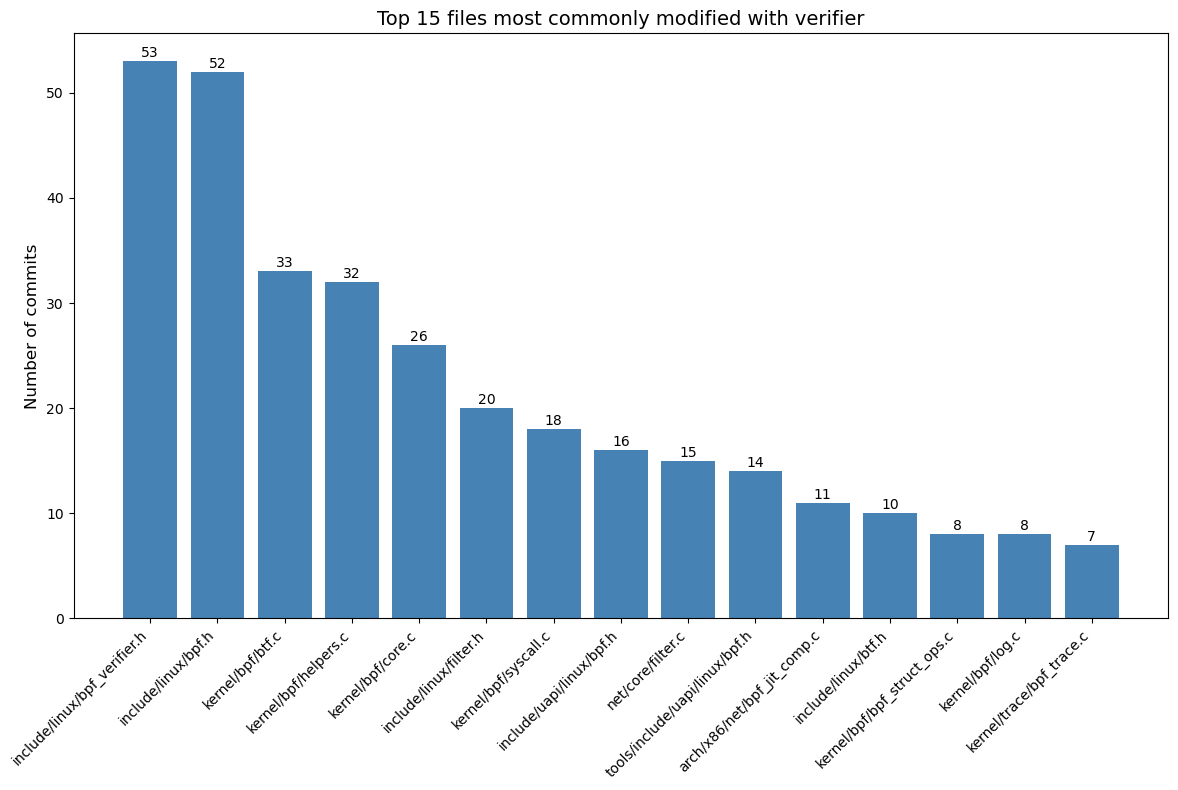

In [37]:
from collections import Counter

def co_occurring_files(title, commits):
    # Count co-occurrences of other files with verifier.c
    co_occurring_files = []
    for commit in commits:
        for file in commit['modified_files']:
            if file != 'kernel/bpf/verifier.c':  # Exclude verifier.c itself
                co_occurring_files.append(file)
    
    # Count occurrences of each file
    file_counts = Counter(co_occurring_files)
    
    # Get the top 15 most frequently co-occurring files
    top_files = file_counts.most_common(15)
    files, counts = zip(*top_files)
    
    # Create bar chart
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(len(files)), counts, color='steelblue')
    
    # Add file names as labels, rotated for readability
    plt.xticks(range(len(files)), files, rotation=45, ha='right')
    plt.ylabel('Number of commits', fontsize=12)
    plt.title(title, fontsize=14)
    
    # Add count labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

co_occurring_files('Top 15 files most commonly modified with verifier', commits)

Seeing `include/linux/bpf_verifier.h` at the top is good news. In my opinion, refactoring this file into `kernel/bpf/bpf_verifier.h` (IOW a private header) not only relatively straightforward, but a good cleanup. It moves the verifier towards being a leaf node rather than its current state of being deeply coupled with other BPF subsystem components. Most of the work in the PoC is undoing such coupling. By moving the header into private header location, it adds some structural guarantees to prevent future backslides, as it'll be harder for other components to start depending on verifier details.

But this is only true if the only other modified file was `bpf_verifier.h`. Let's check that before moving on.

In [30]:
with_bpf_verifier_h = [commit for commit in commits if len(commit['modified_files']) == 2 and 'include/linux/bpf_verifier.h' in commit['modified_files']]
print(f"Number of commits only modifying bpf_verifier.h and verifier.c: {len(with_bpf_verifier_h)}\n")
print_commit_list(with_bpf_verifier_h)

Number of commits only modifying bpf_verifier.h and verifier.c: 24

(51081a3f)  bpf: track changes_pkt_data property for global functions
(96a30e46)  bpf: use common instruction history across all states
(ae6e3a27)  bpf: Drop special callback reference handling
(f6b9a69a)  bpf: Refactor active lock management
(940ce73b)  bpf: Remove the insn_buf array stack usage from the inline_bpf_loop()
(6f606ffd)  bpf: Move insn_buf[16] to bpf_verifier_env
(4bf79f9b)  bpf: Track equal scalars history on per-instruction level
(92424801)  bpf: Fix reg_set_min_max corruption of fake_reg
(0a525621)  bpf: store both map ptr and state in bpf_insn_aux_data
(c1e6148c)  bpf: Preserve boundaries and track scalars on narrowing fill
(41f6f64e)  bpf: support non-r10 register spill/fill to/from stack in precision tracking
(8fa4ecd4)  bpf: enforce exact retval range on subprog/callback exit
(bb124da6)  bpf: keep track of max number of bpf_loop callback iterations
(ab5cfac1)  bpf: verify callbacks as if they are c

Not as many as I hoped. Perhaps there are more nuanced associations present. Let's try to view the full associations.

In [33]:
from collections import Counter

# Get exact sets of files modified in each commit 
# Convert to frozenset so it can be used as a dictionary key
exact_file_sets = Counter([frozenset(commit['modified_files']) for commit in commits])

print("Modified file sets:")
for i, (file_set, count) in enumerate(exact_file_sets.most_common()):
    if len(file_set) == 1:
        print(f"{count:3d} commits: {list(file_set)[0]} (single file)")
    else:
        print(f"{count:3d} commits: {sorted(file_set)} ({len(file_set)} files)")

Modified file sets:
231 commits: kernel/bpf/verifier.c (single file)
 24 commits: ['include/linux/bpf_verifier.h', 'kernel/bpf/verifier.c'] (2 files)
  8 commits: ['kernel/bpf/helpers.c', 'kernel/bpf/verifier.c'] (2 files)
  6 commits: ['include/linux/bpf.h', 'kernel/bpf/btf.c', 'kernel/bpf/verifier.c'] (3 files)
  6 commits: ['kernel/bpf/btf.c', 'kernel/bpf/verifier.c'] (2 files)
  5 commits: ['include/linux/bpf.h', 'kernel/bpf/verifier.c'] (2 files)
  4 commits: ['include/linux/btf.h', 'kernel/bpf/btf.c', 'kernel/bpf/verifier.c'] (3 files)
  4 commits: ['arch/x86/net/bpf_jit_comp.c', 'kernel/bpf/core.c', 'kernel/bpf/verifier.c'] (3 files)
  3 commits: ['include/linux/bpf_verifier.h', 'kernel/bpf/log.c', 'kernel/bpf/verifier.c'] (3 files)
  3 commits: ['include/linux/bpf_verifier.h', 'kernel/bpf/helpers.c', 'kernel/bpf/verifier.c'] (3 files)
  3 commits: ['include/linux/bpf.h', 'include/linux/bpf_verifier.h', 'kernel/bpf/btf.c', 'kernel/bpf/verifier.c'] (4 files)
  2 commits: ['includ

While 24 is somewhat low, the rest appear to be a long tail. So `bpf_verifier.h` next, it is.

Before we move onto part 3, to continue with the bug fix analysis above, we'll look at the file distribution of multi-file bug fixes.

In [12]:
multifile_fixes = [commit for commit in data['commits'] if 'Fixes: ' in commit['message'] and len(commit['modified_files']) > 1]
print(f"Number of multifile commits with 'Fixes:' tag: {len(multifile_fixes)}\n")
print_commit_list(multifile_fixes)

Number of multifile commits with 'Fixes:' tag: 28

(c00d738e)  bpf: Revert "bpf: Mark raw_tp arguments with PTR_MAYBE_NULL"
(12659d28)  bpf: Ensure reg is PTR_TO_STACK in process_iter_arg
(cb4158ce)  bpf: Mark raw_tp arguments with PTR_MAYBE_NULL
(d0b98f6a)  bpf: disallow 40-bytes extra stack for bpf_fastcall patterns
(32556ce9)  bpf: Fix helper writes to read-only maps
(bee109b7)  bpf: Fix error message on kfunc arg type mismatch
(1ae497c7)  bpf: use type_may_be_null() helper for nullable-param check
(92de3608)  bpf: Fail verification for sign-extension of packet data/data_end/data_meta
(5d99e198)  bpf, lsm: Add check for BPF LSM return value
(4bf79f9b)  bpf: Track equal scalars history on per-instruction level
(92424801)  bpf: Fix reg_set_min_max corruption of fake_reg
(aeb8fe02)  bpf: Fix bpf_session_cookie BTF_ID in special_kfunc_set list
(0db63c0b)  bpf: Fix verifier assumptions about socket->sk
(66e13b61)  bpf: verifier: prevent userspace memory access
(e6be8cd5)  bpf: Fix error 

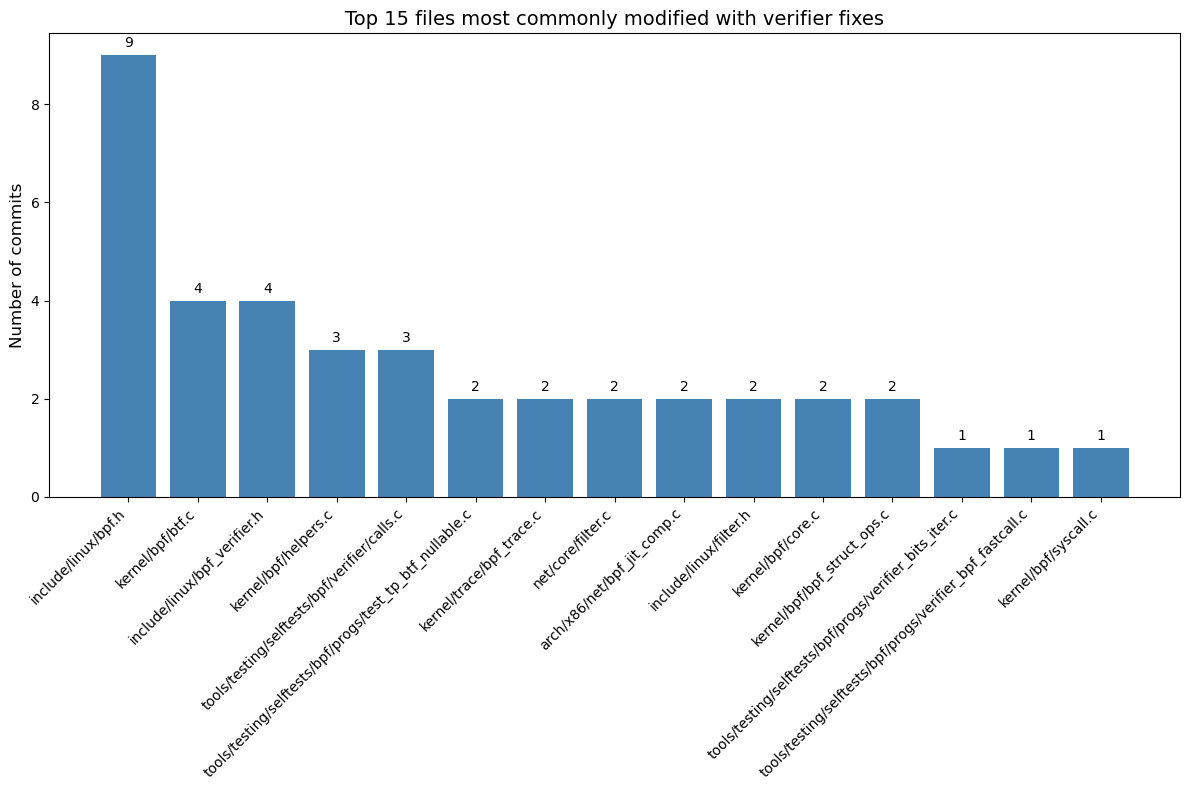

In [36]:
co_occurring_files('Top 15 files most commonly modified with verifier fixes', multifile_fixes)

Unfortunately, no outsized improvements available. We'll ignore `include/linux/bpf.h` as that file is quite large and not practical to tackle right now.

# Part 3: Patchset analysis

As mentioned in the exposition to part 1, intra-patchset dependencies may confound the above analysis. Part 3 analyzes such patchsets.

Data collection was slightly more sophisticated (read: more error prone) for this, as patchset history is harder to grab from git history. Nonetheless, after the below analysis, it seems I did it correct. Full source code for dataset collection is available at: https://github.com/danobi/verifier-analysis.

In [63]:
import itertools

with open('patchsets.json', 'r') as f:
    patchsets = json.load(f)

# Grab a list of all patchset commits
patchsets_commits = list(itertools.chain(*[copy.deepcopy(patchset['commits']) for patchset in patchsets['patchsets']]))
print(f"Number of total patchset commits: {len(patchsets_commits)}")

# Same as with commits.json dataset, ignore selftest changes
for commit in patchsets_commits:
    commit['modified_files'] = [f for f in commit['modified_files'] if 'selftests' not in f]

# Check that verifier-only commits form patchsets.json is subset of same in commits.json
only_verifier_shas = set(commit['hash'] for commit in only_verifier)
patchsets_commits_only_verifier = [commit for commit in patchsets_commits if commit['modified_files'] == ['kernel/bpf/verifier.c']]
patchsets_commits_only_verifier_shas = set(commit['hash'] for commit in patchsets_commits_only_verifier)
assert patchsets_commits_only_verifier_shas.issubset(only_verifier_shas)

# For spot checking the dataset is valid
print(f"Number of commits only modifying verifier: {len(patchsets_commits_only_verifier)}\n")
print_commit_list(patchsets_commits_only_verifier)

Number of total patchset commits: 714
Number of commits only modifying verifier: 132

(27e88bc4)  bpf: add find_containing_subprog() utility function
(69772f50)  bpf: Don't mark STACK_INVALID as STACK_MISC in mark_stack_slot_misc
(b0e66977)  bpf: Fix narrow scalar spill onto 64-bit spilled scalar slots
(12659d28)  bpf: Ensure reg is PTR_TO_STACK in process_iter_arg
(17c4b65a)  bpf: Allow return values 0 and 1 for kprobe session
(46f7ed32)  bpf: Tighten tail call checks for lingering locks, RCU, preempt_disable
(d402755c)  bpf: Unify resource leak checks
(99dde42e)  bpf: Handle BPF_UPTR in verifier
(ae67b9fb)  bpf: Fix truncation bug in coerce_reg_to_size_sx()
(6cb86a0f)  bpf: fix kfunc btf caching for modules
(00750788)  bpf: Fix indentation issue in epilogue_idx
(d5c47719)  bpf: Adjust BPF_JMP that jumps to the 1st insn of the prologue
(b2ee6d27)  bpf: support bpf_fastcall patterns for kfuncs
(40609093)  bpf: allow bpf_fastcall for bpf_cast_to_kern_ctx and bpf_rdonly_cast
(baebe9aa)  

Following the same method in part 1, we see 132 out of 231 verifier-only commits come through patchsets.

The lower number is surprising at first, but obvious after some spot checking - verifier-only changes are typically standalone, and thus not part of patchsets. This lends credibility to our assumption that the verifier is architecturally a leaf node.

Next, we'll look at all the patchsets that contain verifier-only changes. It'll be hard to automate a dependency analysis, so we'll do it manually.

In [77]:
def patchset_contains(patchset, commits):
    contains = any(commit['hash'] in commits for commit in patchset['commits'])
    not_contains = any(commit['hash'] not in commits for commit in patchset['commits'])
    return contains and not_contains
    
patchsets_with_only_verifier = [patchset for patchset in patchsets['patchsets'] if patchset_contains(patchset, only_verifier_shas)]
print(f"{len(patchsets_with_only_verifier)}/{len(patchsets['patchsets'])} patchsets contain verifier-only commits\n")
print('\n'.join([f"({patchset['merge_hash'][:8]})  {patchset['merge_subject']}" for patchset in patchsets_with_only_verifier]))

76/119 patchsets contain verifier-only commits

(cf8b8763)  Merge branch 'bpf-track-changes_pkt_data-property-for-global-functions'
(e2cf9133)  Merge branch 'fixes-for-stack-with-allow_ptr_leaks'
(d4c44354)  Merge branch 'fix-missing-process_iter_arg-type-check'
(269e7c97)  Merge branch 'bpf-add-uprobe-session-support'
(f2daa5a5)  Merge branch 'fix-resource-leak-checks-for-tail-calls'
(c6fb8030)  Merge branch 'share-user-memory-to-bpf-program-through-task-storage-map'
(ee230090)  Merge branch 'fix-truncation-bug-in-coerce_reg_to_size_sx-and-extend-selftests'
(3f2ac59c)  Merge branch 'fix-caching-of-btf-for-kfuncs-in-the-verifier'
(6fee7a7e)  Merge branch 'bpf-follow-up-on-gen_epilogue'
(f6284563)  Merge branch 'bpf-add-gen_epilogue-to-bpf_verifier_ops'
(d352eca2)  Merge branch 'support-bpf_fastcall-patterns-for-calls-to-kfuncs'
(ffc41ce5)  Merge branch 'support-passing-bpf-iterator-to-kfuncs'
(52839f31)  Merge branch 'no_caller_saved_registers-attribute-for-helper-calls'
(02d9fe1c)  Me

I didn't see any major issues in the ~10 I randomly spot checked. So this kind of issue is probably reasonably uncommon. Good to keep an eye out for anyways.

One thing I did notice was we can ignore changes to `Documentation/` just like to `selftests/` when locating verifier-only commits. But that's for another time.